In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Loading data and definition of the training points

Total available data :  (1000000, 2)
Training points:  torch.Size([26, 1]) torch.Size([26, 1])


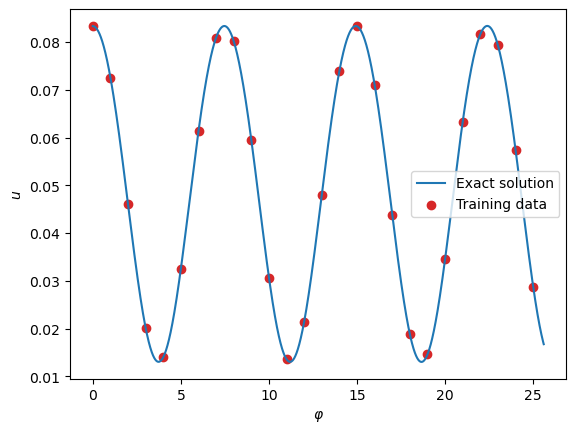

In [4]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Saves GIF file from image files"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


y = np.loadtxt('Schwarzschild_orbit.txt')
print('Total available data : ',y.shape)
phi = torch.from_numpy(y[:640000:10,0]).view(-1,1).to(torch.float32)
u = torch.from_numpy(y[:640000:10,1]).view(-1,1).to(torch.float32)

# slice out a small number of points (10) from the domain
phi_data = phi[0:640000:2500]
u_data = u[0:640000:2500]
print('Training points: ',phi_data.shape, u_data.shape)

# Plot of the exact solution
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.scatter(phi_data, u_data, color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.show()


### Training the Deep Neural Network using only data from the known solution.

In [5]:
class DNN(nn.Module):
    """
    Defines a connected network
    ============================================================================
    N_INPUT: number of input variables
    N_OUTPUT: number of output variables
    N_HIDDEN: number of units per hidden layer
    N_LAYERS: number of hidden layers
    ============================================================================
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh  # The tanh activation restricts output to [-1, 1] 
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        #self.dropout = nn.Dropout(p=0.3)
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [6]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    #plt.scatter(x0, y0, s=60, color="tab:red", alpha=0.4, label='Initial Condition')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 30)
    plt.ylim(0, 0.1)
    plt.text(30.,0.01,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

### Definition of the PINN and training using data from the differential equation, the initial condition and some known data from the exact solution.

In [7]:
def ODE(model, x):
    """
    ODE of the orbit in Newtonian gravity.
    """

    y = model(x)
    # computes dy/dx
    dydx  = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    # computes d^2y/dx^2
    dydx2 = torch.autograd.grad(dydx,  x, torch.ones_like(dydx),  create_graph=True)[0]
    # computes the differential equation
    ode = dydx2 + y - M/L**2 - mu*3*M*y**2
    return ode

Epoch:  500  Loss:  0.0004951174487359822
Epoch:  1000  Loss:  0.0004473094886634499
Epoch:  1500  Loss:  0.0004299797583371401
Epoch:  2000  Loss:  0.00042221200419589877
Epoch:  2500  Loss:  0.00042409790330566466
Epoch:  3000  Loss:  0.00041049724677577615
Epoch:  3500  Loss:  0.0004179544630460441
Epoch:  4000  Loss:  0.0004023972142022103
Epoch:  4500  Loss:  0.00041941541712731123
Epoch:  5000  Loss:  0.0003977601008955389
Epoch:  5500  Loss:  0.0003940673195756972
Epoch:  6000  Loss:  0.00040117010939866304
Epoch:  6500  Loss:  0.00039217586163431406
Epoch:  7000  Loss:  0.00038928177673369646
Epoch:  7500  Loss:  0.0003935323329642415
Epoch:  8000  Loss:  0.00038835732266306877
Epoch:  8500  Loss:  0.00040764306322671473
Epoch:  9000  Loss:  0.0003867355699185282
Epoch:  9500  Loss:  0.0003845391911454499
Epoch:  10000  Loss:  0.00038534324266947806
Epoch:  10500  Loss:  0.00038249348290264606
Epoch:  11000  Loss:  0.00038490735460072756
Epoch:  11500  Loss:  0.0003811733622569

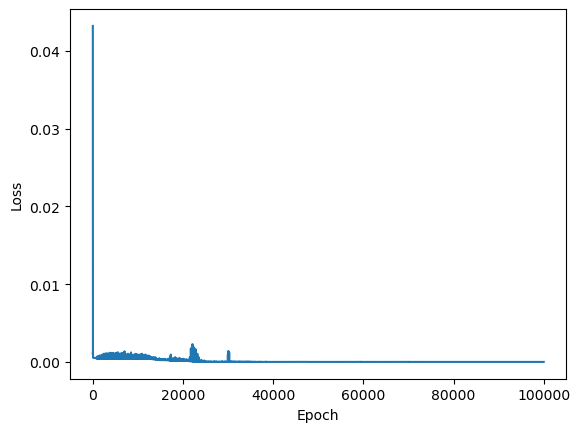

In [8]:




# Sample locations over the problem domain
phi_physics = torch.linspace(0,25,150).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
M=1
L=5

# treat mu as a learnable parameter
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []



epochs = 100000
torch.manual_seed(413)
model = DNN(1,1,32,5)
#optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
optimizer = torch.optim.Adam(list(model.parameters())+[mu],lr=1e-3)


files = []
loss_history = []
bestModel = model
bestLoss = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data)
    loss1 = torch.mean((u_pred - u_data)**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss2 = (1e-1)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()

    # record mu value
    mus.append(mu.item())

    loss_history.append(loss.item())
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        bestModel = model

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        u_pred = model(phi).detach()
        phip = phi_physics.detach()
        
        plot_result(phi,u,phi_data,u_data,u_pred,phip)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())


save_gif_PIL("pinn1.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Best loss:  3.5778604523528657e-09


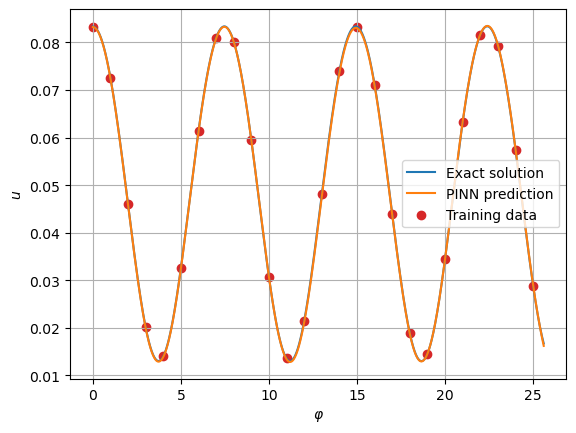

In [9]:
print('Best loss: ', bestLoss)

# Plot the final result
u_pred = bestModel(phi).detach()
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.plot(phi, u_pred, label="PINN prediction")
plt.scatter(phi_data, u_data, color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


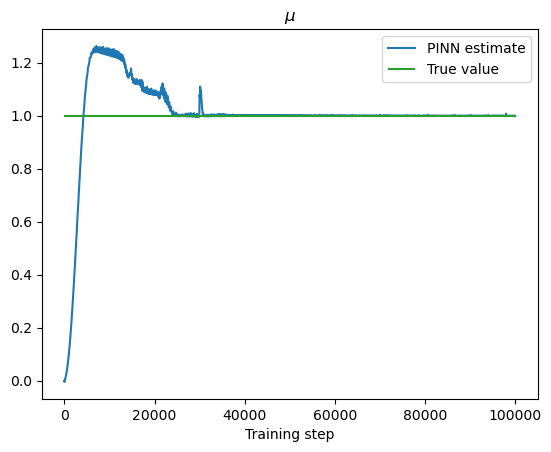

In [11]:
plt.figure()
plt.title(r"$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(1, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

### Definition of the PINN and training using data from the differential equation and less data.

Total available data :  (1000000, 2)
Training points:  torch.Size([26, 1]) torch.Size([26, 1])


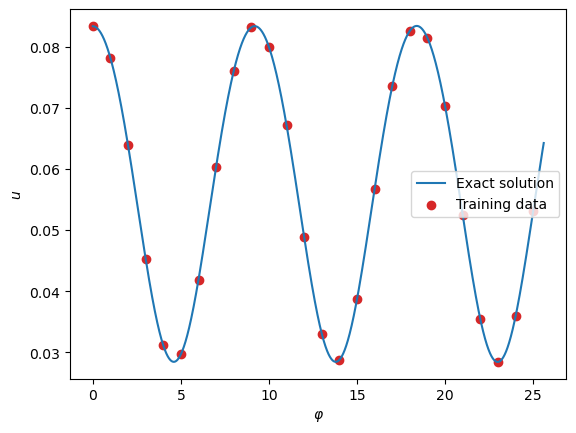

In [12]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Saves GIF file from image files"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


y = np.loadtxt('Schwarzschild_MOD_orbit.txt')
print('Total available data : ',y.shape)
phi = torch.from_numpy(y[:640000:10,0]).view(-1,1).to(torch.float32)
u = torch.from_numpy(y[:640000:10,1]).view(-1,1).to(torch.float32)

# slice out a small number of points (10) from the domain
phi_data = phi[0:640000:2500]
u_data = u[0:640000:2500]
print('Training points: ',phi_data.shape, u_data.shape)

# Plot of the exact solution
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.scatter(phi_data, u_data, color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.show()


Epoch:  500  Loss:  0.00028424596530385315
Epoch:  1000  Loss:  0.0002684115606825799
Epoch:  1500  Loss:  0.00025797353009693325
Epoch:  2000  Loss:  0.0002468640450388193
Epoch:  2500  Loss:  0.00024004960141610354
Epoch:  3000  Loss:  0.00023354805307462811
Epoch:  3500  Loss:  0.00022900867043063045
Epoch:  4000  Loss:  0.0002289722760906443
Epoch:  4500  Loss:  0.00022656669898424298
Epoch:  5000  Loss:  0.0002245720534119755
Epoch:  5500  Loss:  0.00022309395717456937
Epoch:  6000  Loss:  0.00023444148246198893
Epoch:  6500  Loss:  0.00022280220582615584
Epoch:  7000  Loss:  0.00022134999744594097
Epoch:  7500  Loss:  0.00022040048497729003
Epoch:  8000  Loss:  0.0004733815439976752
Epoch:  8500  Loss:  0.00022097972396295518
Epoch:  9000  Loss:  0.00021922081941738725
Epoch:  9500  Loss:  0.00021793716587126255
Epoch:  10000  Loss:  0.00023415617761202157
Epoch:  10500  Loss:  0.0002156474656658247
Epoch:  11000  Loss:  0.00020709136151708663
Epoch:  11500  Loss:  0.000226759628

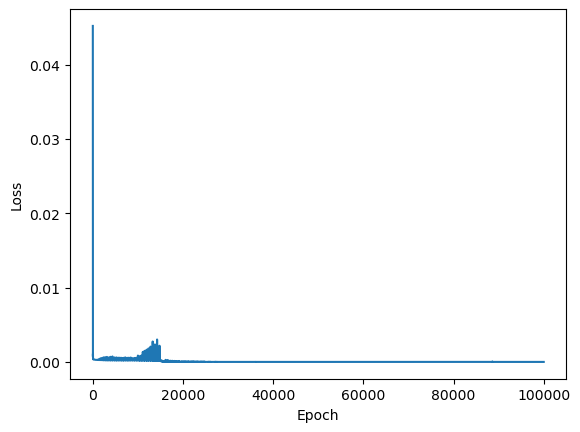

In [13]:




# Sample locations over the problem domain
phi_physics = torch.linspace(0,25,150).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
M=1
L=5

# treat mu as a learnable parameter
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []



epochs = 100000
torch.manual_seed(413)
model = DNN(1,1,32,5)
#optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
optimizer = torch.optim.Adam(list(model.parameters())+[mu],lr=1e-3)


files = []
loss_history = []
bestModel = model
bestLoss = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data)
    loss1 = torch.mean((u_pred - u_data)**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss2 = (1e-1)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()

    # record mu value
    mus.append(mu.item())

    loss_history.append(loss.item())
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        bestModel = model

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        u_pred = model(phi).detach()
        phip = phi_physics.detach()
        
        plot_result(phi,u,phi_data,u_data,u_pred,phip)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())


save_gif_PIL("pinn2.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Best loss:  1.9994916833354637e-09


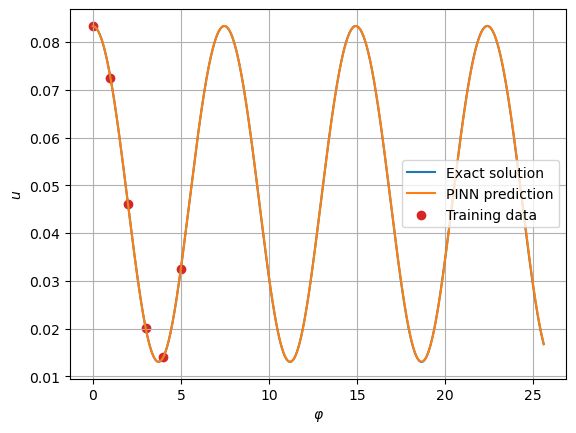

In [34]:
print('Best loss: ', bestLoss)

# Plot the final result
u_pred = bestModel(phi).detach()
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.plot(phi, u_pred, label="PINN prediction")
plt.scatter(phi_data, u_data, color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


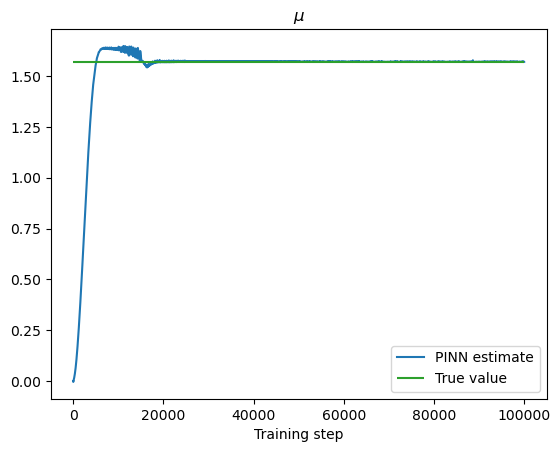

In [15]:
plt.figure()
plt.title(r"$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(np.pi/2, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

In [18]:
mus[-1]

1.570015788078308

In [19]:
np.pi/2

1.5707963267948966

### Definition of the PINN and training using data from the differential equation and the initial condition.

Epoch:  500  Loss:  2.8332397050689906e-07
Epoch:  1000  Loss:  2.336765163590826e-07
Epoch:  1500  Loss:  2.0004074485768797e-07
Epoch:  2000  Loss:  1.7809426822168462e-07
Epoch:  2500  Loss:  1.646830298795976e-07
Epoch:  3000  Loss:  1.5447868406681664e-07
Epoch:  3500  Loss:  1.4338004916680802e-07
Epoch:  4000  Loss:  1.463902776777104e-07
Epoch:  4500  Loss:  1.4418202454180573e-07
Epoch:  5000  Loss:  1.5607371040005091e-07
Epoch:  5500  Loss:  1.4920566115961265e-07
Epoch:  6000  Loss:  1.4605049614146992e-07
Epoch:  6500  Loss:  1.5576628697999695e-07
Epoch:  7000  Loss:  1.4550694515946816e-07
Epoch:  7500  Loss:  1.5389952068289858e-07
Epoch:  8000  Loss:  1.425102027496905e-07
Epoch:  8500  Loss:  1.499790727166328e-07
Epoch:  9000  Loss:  1.390614414731317e-07
Epoch:  9500  Loss:  1.516324630301824e-07
Epoch:  10000  Loss:  1.3750604921369813e-07
Epoch:  10500  Loss:  1.406526592973023e-07
Epoch:  11000  Loss:  1.4135173387330724e-07
Epoch:  11500  Loss:  1.40702709927609

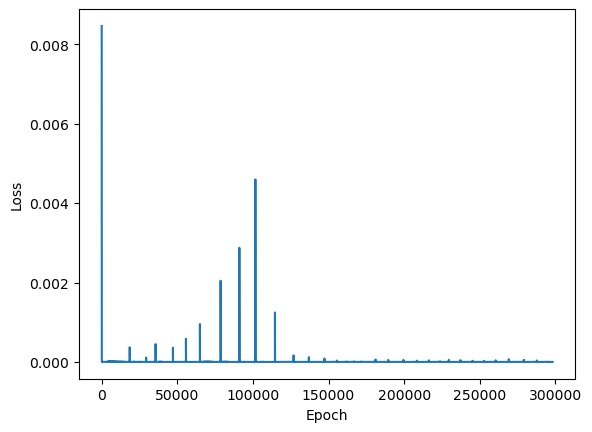

In [23]:

# Sample locations over the problem domain
phi_physics = torch.linspace(0,25,200).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
M=1
L=5


epochs = 400000
torch.manual_seed(413)
model = DNN(1,1,32,7)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []
bestModel3 = model
bestLoss3 = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data[:1])
    loss1 = torch.mean((u_pred - u_data[:1])**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss2 = (1e-2)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if loss.item() < bestLoss3:
        bestLoss3 = loss.item()
        bestModel3 = model
    if loss.item() < 6e-11: break

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        u_pred = model(phi).detach()
        phip = phi_physics.detach()
        
        plot_result(phi,u,phi_data[:1],u_data[:1],u_pred,phip)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())


save_gif_PIL("pinn3.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Best loss:  5.997616986386234e-11


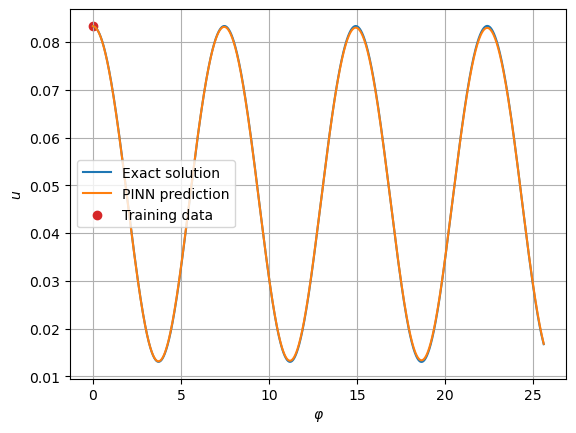

In [24]:
print('Best loss: ', bestLoss3)

# Plot the final result
u_pred = bestModel3(phi).detach()
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.plot(phi, u_pred, label="PINN prediction")
plt.scatter(phi_data[:1], u_data[:1], color="tab:red", label="Training data")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()


Best loss:  5.997616986386234e-11


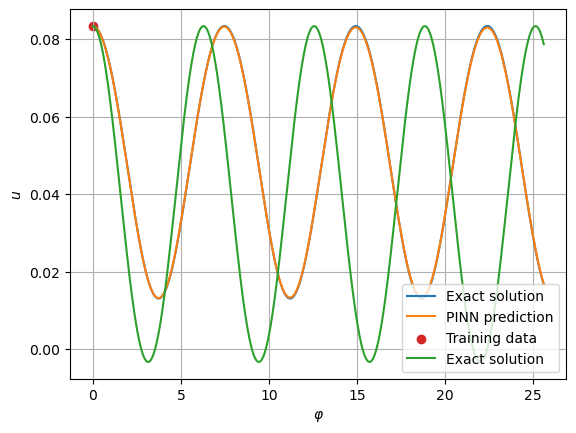

In [34]:
print('Best loss: ', bestLoss3)

# Plot the final result
u_pred = bestModel3(phi).detach()
plt.figure()
plt.plot(phi, u, label="Exact solution")
plt.plot(phi, u_pred, label="PINN prediction")
plt.scatter(phi_data[:1], u_data[:1], color="tab:red", label="Training data")
plt.plot(phi, (M/L**2)*(1 + (L**2/(M*12)-1)*np.cos(phi)), label="Exact solution")
plt.xlabel(r"$\varphi$")
plt.ylabel(r"$u$")
plt.legend()
plt.grid()
plt.show()

Epoch:  500  Loss:  2.8332397050689906e-07
Epoch:  1000  Loss:  2.336765163590826e-07
Epoch:  1500  Loss:  2.0004074485768797e-07
Epoch:  2000  Loss:  1.7809426822168462e-07
Epoch:  2500  Loss:  1.646830298795976e-07
Epoch:  3000  Loss:  1.5447868406681664e-07
Epoch:  3500  Loss:  1.4338004916680802e-07
Epoch:  4000  Loss:  1.463902776777104e-07
Epoch:  4500  Loss:  1.4418202454180573e-07
Epoch:  5000  Loss:  1.5607371040005091e-07
Epoch:  5500  Loss:  1.4920566115961265e-07
Epoch:  6000  Loss:  1.4605049614146992e-07
Epoch:  6500  Loss:  1.5576628697999695e-07
Epoch:  7000  Loss:  1.4550694515946816e-07
Epoch:  7500  Loss:  1.5389952068289858e-07
Epoch:  8000  Loss:  1.425102027496905e-07
Epoch:  8500  Loss:  1.499790727166328e-07
Epoch:  9000  Loss:  1.390614414731317e-07
Epoch:  9500  Loss:  1.516324630301824e-07
Epoch:  10000  Loss:  1.3750604921369813e-07
Epoch:  10500  Loss:  1.406526592973023e-07
Epoch:  11000  Loss:  1.4135173387330724e-07
Epoch:  11500  Loss:  1.40702709927609

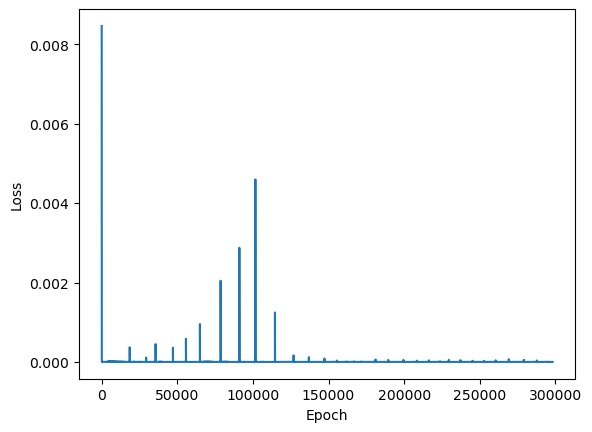

In [39]:

# Sample locations over the problem domain
phi_physics = torch.linspace(0,25,200).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
M=1
L=5


epochs = 400000
torch.manual_seed(413)
model = DNN(1,1,32,7)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []
bestModel4 = model
bestLoss4 = 1e10

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "data loss"
    u_pred = model(phi_data[:1])
    loss1 = torch.mean((u_pred - u_data[:1])**2)# use mean squared error

    # compute the "physics loss"
    physics = ODE(model, phi_physics)
    loss2 = (1e-2)*torch.mean(physics**2)

    # Total loss
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if loss.item() < bestLoss4:
        bestLoss4 = loss.item()
        bestModel4 = model
    if loss.item() < 6e-11: break

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()